## I. Data Treatment

### I.1. Imports

In [65]:
import numpy as np
import pandas as pd
import torch
from tqdm import tqdm
from datetime import datetime

In [4]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import re
nltk.download('vader_lexicon')
from transformers import BertTokenizer, BertForSequenceClassification
nltk.download('stopwords')
nltk.download('punkt')
import emoji
import string
from langdetect import detect, DetectorFactory
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
tqdm.pandas()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/mehdimouden/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/mehdimouden/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/mehdimouden/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [8]:
tweets_raw = pd.read_csv('tweets.csv', sep=';', usecols=['timestamp','text','replies','likes','retweets', 'user'])
tweets_raw.head()

/var/folders/rh/41k8kg5x2js8n7lgg1fb7bj40000gn/T/ipykernel_8693/2445311357.py:1: DtypeWarning: Columns (1,4,8) have mixed types. Specify dtype option on import or set low_memory=False.
  tweets_raw = pd.read_csv('tweets.csv', sep=';', usecols=['timestamp','text','replies','likes','retweets', 'user'])


,user,timestamp,replies,likes,retweets,text
0,KamdemAbdiel,2019-05-27 11:49:14+00,0.0,0.0,0.0,È appena uscito un nuovo video! LES CRYPTOMONN...
1,bitcointe,2019-05-27 11:49:18+00,0.0,0.0,0.0,Cardano: Digitize Currencies; EOS https://t.co...
2,3eyedbran,2019-05-27 11:49:06+00,0.0,2.0,1.0,Another Test tweet that wasn't caught in the s...
3,DetroitCrypto,2019-05-27 11:49:22+00,0.0,0.0,0.0,Current Crypto Prices! \n\nBTC: $8721.99 USD\n...
4,mmursaleen72,2019-05-27 11:49:23+00,0.0,0.0,0.0,Spiv (Nosar Baz): BITCOIN Is An Asset &amp; NO...


In [3]:
tweets_raw.head()

NameError: name 'tweets_raw' is not defined

### I.2. Pre-Processing

In [9]:
# Ensure consistent language detection
DetectorFactory.seed = 0

# Compile regex patterns
url_pattern = re.compile(r"http\S+|www\S+|https\S+")
mention_hashtag_pattern = re.compile(r'\@\w+|\#')

# Compile regular expression patterns
remove_mentions_pattern = re.compile(r'@[\w]+') # Matches mentions
strip_hashtag_pattern = re.compile(r'#([\w]+)') # Matches hashtags but captures only the word

# Load stopwords once
english_stopwords = set(stopwords.words('english'))

# Function to check if text is in English
def is_english(text):
    try:
        return detect(text) == 'en'
    except:
        return False

# Function to preprocess a single text entry
def preprocess_text(text):
    # Check if the text is in English, return None if not
    if not is_english(text):
        return None

    # Convert to lower case
    text = text.lower()
    # Remove URLs
    text = url_pattern.sub('', text)
    # Remove user @ references and '#' from tweet
    # Remove mentions
    text = remove_mentions_pattern.sub('', text)
    # Strip hashtag character
    text = strip_hashtag_pattern.sub(r'\1', text) # \1 refers to the first captured group in the pattern
    #text = mention_hashtag_pattern.sub('', text)
    # Remove punctuations
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Remove emojis by translating them to text
    text = emoji.demojize(text)
    # Tokenize the tweet
    text_tokens = word_tokenize(text)
    # Filter stopwords
    filtered_words = [word for word in text_tokens if word not in english_stopwords]

    return ' '.join(filtered_words)

In [11]:
tweets_processed=tweets_raw.copy()
tweets_processed['timestamp'] = pd.to_datetime(tweets_processed['timestamp'])
tweets_processed = tweets_processed.sort_values(by='timestamp', ascending=True)
tweets_processed.head()

In [14]:
tweets_processed = tweets_processed[(tweets_processed['timestamp'] >= '2016-12-31') & (tweets_processed['timestamp'] <= '2019-11-01')]
tweets_processed.head()

,user,timestamp,replies,likes,retweets,text
2182619,BTCticker,2016-12-31 00:00:06+00:00,0.0,0.0,0.0,One Bitcoin now worth $955.08@bitstamp. High $...
2182618,kobocoindev,2016-12-31 00:00:15+00:00,0.0,0.0,0.0,1 KOBO = 0.00000226 BTC \n = 0.0021 USD \n = 0...
2182617,CryptoAlertBot,2016-12-31 00:01:03+00:00,0.0,0.0,0.0,#BITCOIN ahora:\n$957.09 USD\n€907.97 EUR\n$19...
2182614,btcusd,2016-12-31 00:16:05+00:00,0.0,0.0,0.0,$952.40 at 01:16 UTC [24h Range: $931.00 - $96...
2182615,btcusd,2016-12-31 00:30:03+00:00,0.0,0.0,0.0,$950.59 at 01:30 UTC [24h Range: $931.00 - $96...


In [16]:
tweets_processed=tweets_processed[~((tweets_processed['likes'] == 0) & (tweets_processed['replies'] == 0) & (tweets_processed['retweets'] == 0))]
tweets_processed.head()

,user,timestamp,replies,likes,retweets,text
2182585,btcusd,2016-12-31 03:00:37+00:00,0.0,1.0,1.0,$950.03 at 04:00 UTC [24h Range: $931.00 - $96...
2182572,coinok,2016-12-31 04:17:03+00:00,0.0,1.0,0.0,Order your secure and smart Bitcoin hardware w...
2182570,coinok,2016-12-31 04:27:02+00:00,0.0,1.0,0.0,"Buy Bitcoin With PayPal! Also with CC, paysafe..."
2182569,coinok,2016-12-31 04:30:04+00:00,0.0,1.0,0.0,1 BTC Price: BTC-e 924.476 USD Bitstamp 950.68...
2182567,ThePriceOfBTC,2016-12-31 04:30:25+00:00,0.0,0.0,1.0,$951.38 #bitfinex;\n$950.68 #bitstamp;\n$954.7...


In [17]:
print(len(tweets_processed))

2354473


In [18]:
tqdm.pandas()
# Assuming 'preprocess_text' is your text processing function
# and 'df' is your DataFrame
tweets_processed['text'] = tweets_processed['text'].progress_apply(preprocess_text)
tweets_processed.head()

python(9928) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
100%|██████████| 2354473/2354473 [3:38:42<00:00, 179.42it/s]  


,user,timestamp,replies,likes,retweets,text
2182585,btcusd,2016-12-31 03:00:37+00:00,0.0,1.0,1.0,95003 0400 utc 24h range 93100 96582 volume 11...
2182572,coinok,2016-12-31 04:17:03+00:00,0.0,1.0,0.0,order secure smart bitcoin hardware wallet 348...
2182570,coinok,2016-12-31 04:27:02+00:00,0.0,1.0,0.0,buy bitcoin paypal also cc paysafecard skrill ...
2182569,coinok,2016-12-31 04:30:04+00:00,0.0,1.0,0.0,1 btc price btce 924476 usd bitstamp 95068 usd...
2182567,ThePriceOfBTC,2016-12-31 04:30:25+00:00,0.0,0.0,1.0,95138 bitfinex 95068 bitstamp 95471 gdax 92448...


In [20]:
tweets_processed = tweets_processed.dropna(subset=['text'])

In [24]:
tweets_processed.to_csv('processed.csv', sep=';', index=False) 

In [22]:
print(len(tweets_processed))

1736214


In [5]:
### CHECKPOINT RELOADING ####

tweets_processed=pd.read_csv('processed.csv', sep=';')
tweets_processed['timestamp'] = pd.to_datetime(tweets_processed['timestamp'])
tweets_processed = tweets_processed.dropna(subset=['text'])
tweets_processed.head(50)

##############################

,user,timestamp,replies,likes,retweets,text
0,btcusd,2016-12-31 03:00:37+00:00,0.0,1.0,1.0,95003 0400 utc 24h range 93100 96582 volume 11...
1,coinok,2016-12-31 04:17:03+00:00,0.0,1.0,0.0,order secure smart bitcoin hardware wallet 348...
2,coinok,2016-12-31 04:27:02+00:00,0.0,1.0,0.0,buy bitcoin paypal also cc paysafecard skrill ...
3,coinok,2016-12-31 04:30:04+00:00,0.0,1.0,0.0,1 btc price btce 924476 usd bitstamp 95068 usd...
4,ThePriceOfBTC,2016-12-31 04:30:25+00:00,0.0,0.0,1.0,95138 bitfinex 95068 bitstamp 95471 gdax 92448...
5,btcusd,2016-12-31 04:30:36+00:00,0.0,0.0,1.0,95068 0530 utc 24h range 93100 96582 volume 10...
6,coinok,2016-12-31 04:31:03+00:00,0.0,1.0,0.0,1 doge price bter 000000023 btc doge dogecoin ...
7,coinok,2016-12-31 04:42:02+00:00,0.0,1.0,0.0,hardware bitcoin wallet get trezor 99 btc bitc...
8,CryptoOz,2016-12-31 04:44:19+00:00,0.0,6.0,12.0,surely seeing pattern altcoin crypto bitcoin b...
9,dogecointicker,2016-12-31 05:00:01+00:00,0.0,1.0,0.0,current value doge btc vircurex 000000022 volu...


### I.3. Sentiment Analysis

In [9]:
# Initialize the VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()
# Create a function to apply VADER sentiment analysis and add sentiment scores to the DataFrame
def get_sentiment(text):
    sentiment = analyzer.polarity_scores(text)
    return sentiment
# Create a function to calculate weights for each tweet
def calculate_weights(tweet):
    weight = tweet['likes'] + tweet['retweets'] + tweet['replies']
    return weight #if weight > 0 else 1  # Ensure a non-zero minimum weight
# Create a function to calculate weighted average sentiment
def weighted_average(group):
    weighted_sentiments = group['compound_sentiment'] * group['weight']
    return weighted_sentiments.sum() / group['weight'].sum()

In [10]:
def replace_words_in_dataframe(df, column_name):
    replacements = {
        'fire': 'trending',
        'rocket': 'trending',
        'collision': 'trending',
        ': fire :': 'trending',
        ': rocket :': 'trending',
        ': collision :': 'trending'
    }

    for word, replacement in replacements.items():
        df[column_name] = df[column_name].str.replace(r'\b' + word + r'\b', replacement, regex=True)
    
    return df

In [ ]:
# Apply the sentiment analysis function to the preprocessed 'text' column
#tweets_analysis=tweets_processed.copy()
#tweets_analysis['sentiment'] = tweets_analysis['text'].apply(get_sentiment)
#tweets_analysis['compound_sentiment'] = tweets_analysis['sentiment'].apply(lambda x: x['compound'])
#tweets_analysis.head()
#tweets_analysis.to_csv('vador.csv', index=False)
#tweets_sample_spam = tweets_analysis['text'].tail(10000).to_frame()
#tweets_sample_spam.to_csv('sampled_spam.csv', index=False)
#tweets_analysis_sorted = tweets_analysis.sort_values(by='compound_sentiment', ascending=True)
#tweets_analysis_sorted.head(50)

In [7]:
tqdm.pandas()
# Converting the fire/rocket/collision emojis and getting the sentiment
tweets_analysis=tweets_processed.copy()
tweets_analysis = replace_words_in_dataframe(tweets_analysis, 'text')

In [11]:
tweets_analysis['sentiment'] = tweets_analysis['text'].progress_apply(get_sentiment)
tweets_analysis['compound_sentiment'] = tweets_analysis['sentiment'].apply(lambda x: x['compound'])
tweets_analysis.head()

100%|██████████| 1733237/1733237 [06:42<00:00, 4301.44it/s]


,user,timestamp,replies,likes,retweets,text,sentiment,compound_sentiment
0,btcusd,2016-12-31 03:00:37+00:00,0.0,1.0,1.0,95003 0400 utc 24h range 93100 96582 volume 11...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000
1,coinok,2016-12-31 04:17:03+00:00,0.0,1.0,0.0,order secure smart bitcoin hardware wallet 348...,"{'neg': 0.0, 'neu': 0.662, 'pos': 0.338, 'comp...",0.6249
2,coinok,2016-12-31 04:27:02+00:00,0.0,1.0,0.0,buy bitcoin paypal also cc paysafecard skrill ...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000
3,coinok,2016-12-31 04:30:04+00:00,0.0,1.0,0.0,1 btc price btce 924476 usd bitstamp 95068 usd...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000
4,ThePriceOfBTC,2016-12-31 04:30:25+00:00,0.0,0.0,1.0,95138 bitfinex 95068 bitstamp 95471 gdax 92448...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000


In [12]:
tweets_analysis['text'] = tweets_analysis['text'].apply(lambda x: ' '.join(word for word in x.split() if 'pictwitter' not in word))

In [13]:
tweets_analysis.to_csv('vador.csv', sep=';' , index=False) ### CHECKPOINT RELOADING ####

In [14]:
### CHECKPOINT RELOADING ####


#tweets_analysis=pd.read_csv('vador.csv', sep=';')

In [44]:
tweets_analysis_sorted = tweets_analysis.sort_values(by='compound_sentiment', ascending=False)

In [45]:
tweets_analysis_sorted.head(50)

,user,timestamp,replies,likes,retweets,text,sentiment,compound_sentiment
7166069,GoddessFoxes,2019-05-22 15:36:13+00:00,0.0,5.0,3.0,500 goal friday : money_bag : :double_exclamat...,"{'neg': 0.0, 'neu': 0.215, 'pos': 0.785, 'comp...",0.9955
17144858,johnkim77,2019-10-04 05:50:11+00:00,4.0,53.0,8.0,like bitcoin love litecoin like store value lo...,"{'neg': 0.0, 'neu': 0.187, 'pos': 0.813, 'comp...",0.9953
16349728,brandonlharris,2019-09-21 14:25:28+00:00,4.0,6.0,3.0,ill giveaway 25 via cashapp 25 worth bitcoin p...,"{'neg': 0.036, 'neu': 0.245, 'pos': 0.719, 'co...",0.9949
14270941,burka24,2019-08-22 22:11:45+00:00,0.0,0.0,1.0,play game earn free btc play game earn free bt...,"{'neg': 0.0, 'neu': 0.372, 'pos': 0.628, 'comp...",0.9927
8251273,braincramps,2018-10-15 18:45:48+00:00,0.0,1.0,1.0,bitcoinfreedom freedom fiat freedom trade wout...,"{'neg': 0.0, 'neu': 0.335, 'pos': 0.665, 'comp...",0.9911
15856644,Litecoin_MAD,2019-09-14 20:53:24+00:00,2.0,3.0,2.0,freedom speech freedom information freedom rel...,"{'neg': 0.0, 'neu': 0.261, 'pos': 0.739, 'comp...",0.9905
7836414,BullyEsq,2019-06-06 01:02:54+00:00,13.0,73.0,3.0,bitcoin diamond lol lol worth hahaha hold ’ wo...,"{'neg': 0.0, 'neu': 0.292, 'pos': 0.708, 'comp...",0.9903
14337894,smorgsinnit,2019-08-23 23:03:49+00:00,2.0,4.0,3.0,lovely coffee perth weekend read : camera_with...,"{'neg': 0.0, 'neu': 0.319, 'pos': 0.681, 'comp...",0.9903
10565142,NoahPierau,2019-07-04 09:18:18+00:00,3.0,37.0,13.0,dcr superior store value dcr superior store va...,"{'neg': 0.0, 'neu': 0.253, 'pos': 0.747, 'comp...",0.9901
8083404,malithi323,2019-06-10 11:34:33+00:00,0.0,7.0,4.0,great vision huge potential make huge history ...,"{'neg': 0.0, 'neu': 0.277, 'pos': 0.723, 'comp...",0.9892


In [46]:
tweets_analysis_sorted.tail(50)

,user,timestamp,replies,likes,retweets,text,sentiment,compound_sentiment
924209,karolcummins,2019-05-20 23:54:04+00:00,1.0,34.0,21.0,: bomb : incoming10 : bomb : 1500 americans jo...,"{'neg': 0.512, 'neu': 0.488, 'pos': 0.0, 'comp...",-0.9756
13789424,Rakesh_swain62,2019-08-15 15:33:57+00:00,1.0,1.0,1.0,people feared electricity people feared first ...,"{'neg': 0.593, 'neu': 0.407, 'pos': 0.0, 'comp...",-0.9757
5421051,lestherat,2018-08-02 10:25:49+00:00,1.0,5.0,0.0,fuck waves dumpers stupid retards hell really ...,"{'neg': 0.729, 'neu': 0.271, 'pos': 0.0, 'comp...",-0.9757
13789013,AltcoinSara,2019-08-15 15:26:10+00:00,11.0,149.0,34.0,people feared electricity people feared first ...,"{'neg': 0.593, 'neu': 0.407, 'pos': 0.0, 'comp...",-0.9757
14976484,JacobCanfield,2019-09-03 04:12:16+00:00,14.0,251.0,18.0,cryptocurrency trader armed robber armed robbe...,"{'neg': 0.651, 'neu': 0.349, 'pos': 0.0, 'comp...",-0.9758
14726155,7seven4peace,2019-08-30 01:36:23+00:00,0.0,0.0,1.0,bitcoin eth jabatanpenerangan sayangimalaysiak...,"{'neg': 0.572, 'neu': 0.428, 'pos': 0.0, 'comp...",-0.9761
1279878,RituG15,2019-05-17 09:42:40+00:00,0.0,6.0,6.0,cannes2019 london brexit bitcoin mrlocalmanias...,"{'neg': 0.53, 'neu': 0.333, 'pos': 0.137, 'com...",-0.9766
7605319,Bleeding_Crypto,2019-06-03 15:04:53+00:00,57.0,499.0,25.0,btc got done blocking ton people talking shit ...,"{'neg': 0.673, 'neu': 0.327, 'pos': 0.0, 'comp...",-0.9771
16474744,Rhythmtrader,2019-09-23 18:18:55+00:00,20.0,595.0,183.0,president said bitcoin based thin air budget d...,"{'neg': 0.561, 'neu': 0.393, 'pos': 0.046, 'co...",-0.9771
10957089,paddystash,2019-07-10 00:28:10+00:00,27.0,152.0,30.0,altcoins dead altcoins going die hell alt coin...,"{'neg': 0.5, 'neu': 0.5, 'pos': 0.0, 'compound...",-0.9776


In [43]:
#values_to_remove = ['mademoisellesav','Goddessofkush1'] 
#tweets_analysis = tweets_analysis[~tweets_analysis['user'].isin(values_to_remove)]

In [15]:
print(len(tweets_analysis))

1733237


### I.4 Spam detection model and prediction

In [51]:
tweets_sample_spam = tweets_analysis['text'].head(5000).to_frame()
tweets_sample_spam.to_csv('sampled_spam.csv', index=False)

In [54]:
tweets_analysis.head(5000)

,user,timestamp,replies,likes,retweets,text,sentiment,compound_sentiment
2182585,btcusd,2016-12-31 03:00:37+00:00,0.0,1.0,1.0,95003 0400 utc 24h range 93100 96582 volume 11...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000
2182572,coinok,2016-12-31 04:17:03+00:00,0.0,1.0,0.0,order secure smart bitcoin hardware wallet 348...,"{'neg': 0.0, 'neu': 0.662, 'pos': 0.338, 'comp...",0.6249
2182570,coinok,2016-12-31 04:27:02+00:00,0.0,1.0,0.0,buy bitcoin paypal also cc paysafecard skrill ...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000
2182569,coinok,2016-12-31 04:30:04+00:00,0.0,1.0,0.0,1 btc price btce 924476 usd bitstamp 95068 usd...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000
2182567,ThePriceOfBTC,2016-12-31 04:30:25+00:00,0.0,0.0,1.0,95138 bitfinex 95068 bitstamp 95471 gdax 92448...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000
...,...,...,...,...,...,...,...,...
3017358,moshoodIsiaka4,2017-02-16 19:37:15+00:00,2.0,0.0,0.0,want buy bitcoin,"{'neg': 0.0, 'neu': 0.606, 'pos': 0.394, 'comp...",0.0772
3017343,bitcoinfirehose,2017-02-16 19:39:12+00:00,0.0,1.0,0.0,updated list vape shops accept bitcoin reddit ...,"{'neg': 0.0, 'neu': 0.729, 'pos': 0.271, 'comp...",0.3818
3017337,BourseetTrading,2017-02-16 19:39:42+00:00,0.0,12.0,14.0,infographic unterstand part blockchain technol...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000
3017317,BYODre,2017-02-16 19:40:41+00:00,0.0,6.0,4.0,bitcoin build blockchain shared decentralized ...,"{'neg': 0.0, 'neu': 0.769, 'pos': 0.231, 'comp...",0.3400


In [50]:
######################### Spam and Information Model Detection #############################
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
logistic_regression_classifier = LogisticRegression()
from sklearn.svm import SVC
svm_classifier = SVC()
from sklearn.ensemble import RandomForestClassifier
random_forest_classifier = RandomForestClassifier()
from sklearn.svm import SVC

In [24]:
# Load data (replace 'your_data.csv' with your file path)
tweets_sample_annotated = pd.read_csv('sampled_spam_annotated.csv', sep=';')
tweets_sample_annotated = tweets_sample_annotated.dropna(subset=['text'])
tweets_sample_annotated['spam'] = tweets_sample_annotated['spam'].fillna(0)
tweets_sample_annotated.head(50)

,text,spam
0,95003 0400 utc 24h range 93100 96582 volume 11...,1.0
1,order secure smart bitcoin hardware wallet 348...,1.0
2,buy bitcoin paypal also cc paysafecard skrill ...,1.0
3,1 btc price btce 924476 usd bitstamp 95068 usd...,1.0
4,95138 bitfinex 95068 bitstamp 95471 gdax 92448...,1.0
5,95068 0530 utc 24h range 93100 96582 volume 10...,1.0
6,1 doge price bter 000000023 btc doge dogecoin ...,1.0
7,hardware bitcoin wallet get trezor 99 btc bitc...,1.0
8,surely seeing pattern altcoin crypto bitcoin b...,0.0
9,current value doge btc vircurex 000000022 volu...,1.0


In [25]:
#
X = tweets_sample_annotated['text']
y = tweets_sample_annotated['spam']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

tfidf_vectorizer = TfidfVectorizer(stop_words='english')
naive_bayes_classifier = MultinomialNB()
model = Pipeline([
    ('vectorizer', tfidf_vectorizer),
    ('classifier', naive_bayes_classifier)
])

In [26]:
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(f"Classification Report:\n{classification_report(y_test, y_pred)}")
print(f"Confusion Matrix:\n{confusion_matrix(y_test, y_pred)}")
print(f"Accuracy Score: {accuracy_score(y_test, y_pred)}")

Classification Report:
              precision    recall  f1-score   support

         0.0       0.85      0.73      0.78       229
         1.0       0.85      0.92      0.88       378

    accuracy                           0.85       607
   macro avg       0.85      0.82      0.83       607
weighted avg       0.85      0.85      0.85       607

Confusion Matrix:
[[167  62]
 [ 30 348]]
Accuracy Score: 0.8484349258649094


In [27]:
##################### PREDICT IN TWEETS_ANALYSIS########################## 
tweets_analysis = tweets_analysis.dropna(subset=['text'])
tweets_analysis_spam = tweets_analysis.copy()
tweets_analysis_spam = tweets_analysis_spam[(tweets_analysis_spam['timestamp'] >= '2017-03-01') & (tweets_analysis_spam['timestamp'] <= '2019-11-01')]
# Predict spam for the new data
predicted_spam = model.predict(tweets_analysis_spam['text'])

# Add predictions to the DataFrame
tweets_analysis_spam['spam'] = predicted_spam

tweets_analysis_spam.head(1000)

,user,timestamp,replies,likes,retweets,text,sentiment,compound_sentiment,spam
10128,MeetStevenSun,2017-03-01 00:19:40+00:00,0.0,1.0,0.0,1 tbc 236829334 btc 1 tbc 290900 buy tbc today,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,1.0
10129,CryptoOz,2017-03-01 00:56:19+00:00,1.0,2.0,23.0,ai sake humanity us see past present : OK_hand...,"{'neg': 0.0, 'neu': 0.645, 'pos': 0.355, 'comp...",0.7650,0.0
10130,cazushi0321,2017-03-01 01:30:23+00:00,0.0,0.0,2.0,xbinaryinvestment day 18dividend 200％roi 3064％...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,1.0
10131,cazushi0321,2017-03-01 01:30:59+00:00,0.0,0.0,1.0,onepunchltdinvestment day 9dividend 600％roi 42...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,1.0
10132,Bitcoin555,2017-03-01 02:20:54+00:00,2.0,10.0,8.0,start bitcoinmining original bitcoin mining co...,"{'neg': 0.0, 'neu': 0.753, 'pos': 0.247, 'comp...",0.3182,0.0
...,...,...,...,...,...,...,...,...,...
11123,CryptoPressNews,2017-03-23 23:01:15+00:00,0.0,1.0,2.0,dailydowns btc bcn 2000 btc nobl 1818 btc emc2...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,1.0
11124,FinFreeFlex,2017-03-24 00:38:47+00:00,1.0,1.0,0.0,let know buy coins right brain wave still earl...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,0.0
11125,coinok,2017-03-24 03:17:02+00:00,0.0,1.0,0.0,order secure smart bitcoin hardware wallet 348...,"{'neg': 0.0, 'neu': 0.662, 'pos': 0.338, 'comp...",0.6249,1.0
11126,coinok,2017-03-24 03:27:02+00:00,0.0,1.0,0.0,buy bitcoin paypal also cc paysafecard skrill ...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,1.0


In [30]:
tweets_analysis_spam[tweets_analysis_spam['user']=='mademoisellesav']['text'].head()

728637    tokenpayscam scam project fake copied redflags...
728650    som die like tokenpayscam scam project fake co...
815894    tokenpayscam scam project fake copied redflags...
815913    tokenpayscam scam project fake copied redflags...
815924    tokenpayscam scam project fake copied redflags...
Name: text, dtype: object

In [75]:
print(len(tweets_analysis_spam))
print(int(sum(tweets_analysis_spam['spam']))/len(tweets_analysis_spam)*100)

1726072
22.74059251294268


In [32]:
tweets_analysis_nospam = tweets_analysis_spam[tweets_analysis_spam['spam']==0]
print(len(tweets_analysis_nospam))

1321128


In [33]:
tweets_analysis_nospam = tweets_analysis_nospam.drop_duplicates(subset=['user', 'text'])
print(len(tweets_analysis_nospam))

1202167


In [35]:
duplicates = tweets_analysis_spam[tweets_analysis_spam.duplicated(subset=['user', 'text'], keep=False)]

In [36]:
print(len(duplicates))
duplicates.head(1000)

172856


,user,timestamp,replies,likes,retweets,text,sentiment,compound_sentiment,spam
10136,coinok,2017-03-01 04:42:02+00:00,0.0,0.0,3.0,hardware bitcoin wallet get trezor 99 btc bitc...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,1.0
10180,CryptoPressNews,2017-03-01 23:00:03+00:00,0.0,1.0,0.0,dailyups btc bcn 2500 btc amp 2240 xmr zec 185...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,1.0
10181,CryptoPressNews,2017-03-01 23:01:04+00:00,0.0,2.0,3.0,dailydowns eth lsk 1767 btc dgb 1600 btc qora ...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,1.0
10199,coinok,2017-03-02 04:42:02+00:00,0.0,0.0,1.0,hardware bitcoin wallet get trezor 99 btc bitc...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,1.0
10269,CryptoPressNews,2017-03-02 23:01:04+00:00,0.0,1.0,0.0,dailydowns eth lsk 1767 btc dgb 1600 btc qora ...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,1.0
...,...,...,...,...,...,...,...,...,...
18058,iworkfromhome4,2017-06-15 03:55:05+00:00,0.0,1.0,0.0,rain money 3step plan entrepreneur mlm bitcoin...,"{'neg': 0.194, 'neu': 0.806, 'pos': 0.0, 'comp...",-0.3400,0.0
18067,CyberDomain,2017-06-15 03:59:43+00:00,0.0,1.0,0.0,bitcoin story,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,0.0
18069,_DuNN0_,2017-06-15 04:00:00+00:00,0.0,2.0,4.0,smart make money copying best crypto trader ea...,"{'neg': 0.0, 'neu': 0.588, 'pos': 0.412, 'comp...",0.8689,0.0
18071,BitcoinEdu,2017-06-15 04:00:03+00:00,0.0,3.0,1.0,fact aug 2013 us court rules bitcoin currency ...,"{'neg': 0.0, 'neu': 0.809, 'pos': 0.191, 'comp...",0.5106,0.0


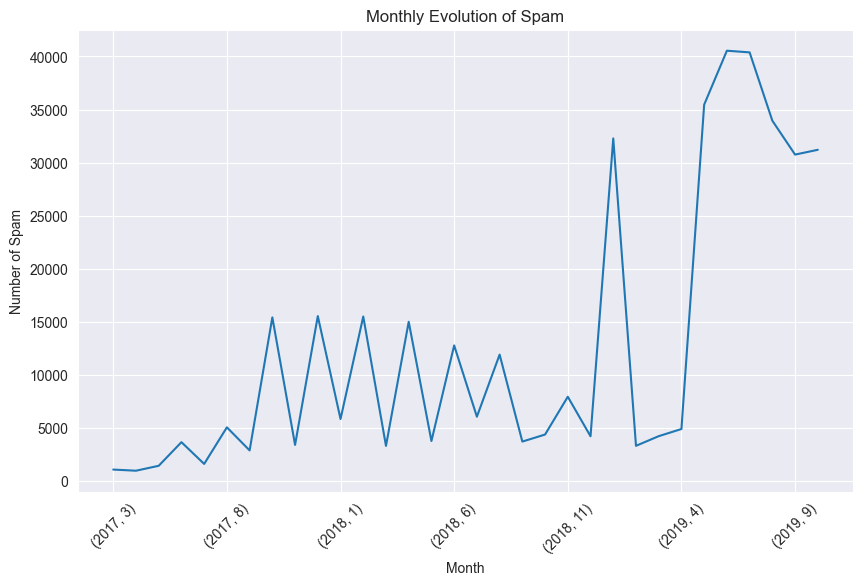

In [37]:
import matplotlib.pyplot as plt
# Group by year and month, and sum spam occurrences
monthly_spam = tweets_analysis_spam.groupby([tweets_analysis_spam['timestamp'].dt.year, tweets_analysis_spam['timestamp'].dt.month])['spam'].sum()
monthly_spam.plot(kind='line', figsize=(10, 6))

plt.title('Monthly Evolution of Spam')
plt.xlabel('Month')
plt.ylabel('Number of Spam')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.grid(True)
plt.show()

In [51]:
# Create a new pipeline with SVM
model_2 = Pipeline([
    ('vectorizer', TfidfVectorizer(stop_words='english')),
    ('classifier', SVC())
])
# Everything else remains the same
model_2.fit(X_train, y_train)
y_pred_2 = model_2.predict(X_test)
# Evaluate the model
print(f"Classification Report:\n{classification_report(y_test, y_pred_2)}")
print(f"Confusion Matrix:\n{confusion_matrix(y_test, y_pred_2)}")
print(f"Accuracy Score: {accuracy_score(y_test, y_pred_2)}")

Classification Report:
              precision    recall  f1-score   support

         0.0       0.80      0.84      0.82       229
         1.0       0.90      0.88      0.89       378

    accuracy                           0.86       607
   macro avg       0.85      0.86      0.86       607
weighted avg       0.87      0.86      0.86       607

Confusion Matrix:
[[193  36]
 [ 47 331]]
Accuracy Score: 0.8632619439868204


In [52]:
# Predict spam for the new data
predicted_spam_2 = model_2.predict(tweets_analysis_spam['text'])

# Add predictions to the DataFrame
tweets_analysis_spam['spam_2'] = predicted_spam_2

tweets_analysis_spam.head(1000)

,user,timestamp,replies,likes,retweets,text,sentiment,compound_sentiment,spam,spam_2
10128,MeetStevenSun,2017-03-01 00:19:40+00:00,0.0,1.0,0.0,1 tbc 236829334 btc 1 tbc 290900 buy tbc today,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,1.0,1.0
10129,CryptoOz,2017-03-01 00:56:19+00:00,1.0,2.0,23.0,ai sake humanity us see past present : OK_hand...,"{'neg': 0.0, 'neu': 0.645, 'pos': 0.355, 'comp...",0.7650,0.0,0.0
10130,cazushi0321,2017-03-01 01:30:23+00:00,0.0,0.0,2.0,xbinaryinvestment day 18dividend 200％roi 3064％...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,1.0,1.0
10131,cazushi0321,2017-03-01 01:30:59+00:00,0.0,0.0,1.0,onepunchltdinvestment day 9dividend 600％roi 42...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,1.0,1.0
10132,Bitcoin555,2017-03-01 02:20:54+00:00,2.0,10.0,8.0,start bitcoinmining original bitcoin mining co...,"{'neg': 0.0, 'neu': 0.753, 'pos': 0.247, 'comp...",0.3182,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
11123,CryptoPressNews,2017-03-23 23:01:15+00:00,0.0,1.0,2.0,dailydowns btc bcn 2000 btc nobl 1818 btc emc2...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,1.0,1.0
11124,FinFreeFlex,2017-03-24 00:38:47+00:00,1.0,1.0,0.0,let know buy coins right brain wave still earl...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,0.0,0.0
11125,coinok,2017-03-24 03:17:02+00:00,0.0,1.0,0.0,order secure smart bitcoin hardware wallet 348...,"{'neg': 0.0, 'neu': 0.662, 'pos': 0.338, 'comp...",0.6249,1.0,1.0
11126,coinok,2017-03-24 03:27:02+00:00,0.0,1.0,0.0,buy bitcoin paypal also cc paysafecard skrill ...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,1.0,1.0


In [53]:
print(int(sum(tweets_analysis_spam['spam_2']))/len(tweets_analysis_spam)*100)

10.933428510077709


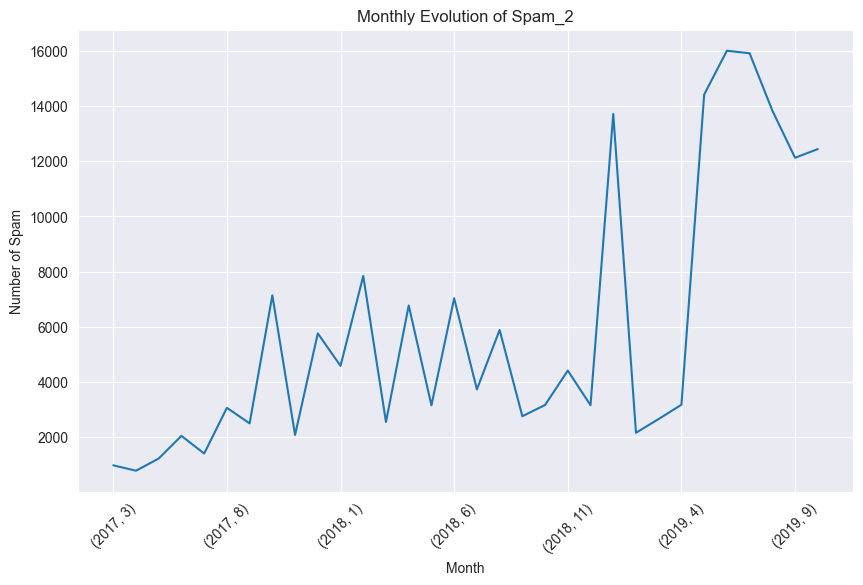

In [55]:
# Group by year and month, and sum spam occurrences
monthly_spam = tweets_analysis_spam.groupby([tweets_analysis_spam['timestamp'].dt.year, tweets_analysis_spam['timestamp'].dt.month])['spam_2'].sum()
monthly_spam.plot(kind='line', figsize=(10, 6))

plt.title('Monthly Evolution of Spam_2')
plt.xlabel('Month')
plt.ylabel('Number of Spam')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.grid(True)
plt.show()

## II. Financial Strategy

All tweets are in UTC, we import data on stocks in UTC time:
- BTC : daily price (open = 00:00 UTC time) -> returns
- BTC : volumes
- ETH : daily price (open = 00:00 UTC time) -> returns
- ETH : volumes
- SPX : daily price (open = 00:00 UTC time) -> returns
- SPX : volumes
- VIX daily change
And we use from our data:
- Daily sentiment 
- Daily volume of tweets
- Daily change in sentiment

In [38]:
import yfinance as yf

# Define the date range for which you want to fetch historical data
start_date = "2017-03-01"
end_date = "2019-11-01"

btcusd = yf.Ticker("BTC-USD").history(start=start_date, end=end_date)
ethusd = yf.Ticker("ETH-USD").history(start=start_date, end=end_date)
spx = yf.Ticker("^GSPC").history(start=start_date, end=end_date)     # S&P 500 Index
vix = yf.Ticker("^VIX").history(start=start_date, end=end_date)      # Volatility Index

# Print the resulting DataFrame
btcusd.head(100)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2017-03-01 00:00:00+00:00,1180.040039,1222.500000,1179.689941,1222.500000,229056992,0.0,0.0
2017-03-02 00:00:00+00:00,1224.680054,1262.130005,1215.619995,1251.010010,368275008,0.0,0.0
2017-03-03 00:00:00+00:00,1250.709961,1280.310059,1250.709961,1274.989990,315739008,0.0,0.0
2017-03-04 00:00:00+00:00,1277.430054,1279.400024,1230.510010,1255.150024,183270000,0.0,0.0
2017-03-05 00:00:00+00:00,1254.290039,1267.290039,1238.060059,1267.119995,134127000,0.0,0.0


In [41]:
btc_normalized = btcusd['Open'] / btcusd['Open'].iloc[0]
eth_normalized = ethusd['Open'] / ethusd['Open'].iloc[0]
spx_normalized = spx['Open'] / spx['Open'].iloc[0]
vix_normalized = vix['Open'] / vix['Open'].iloc[0]

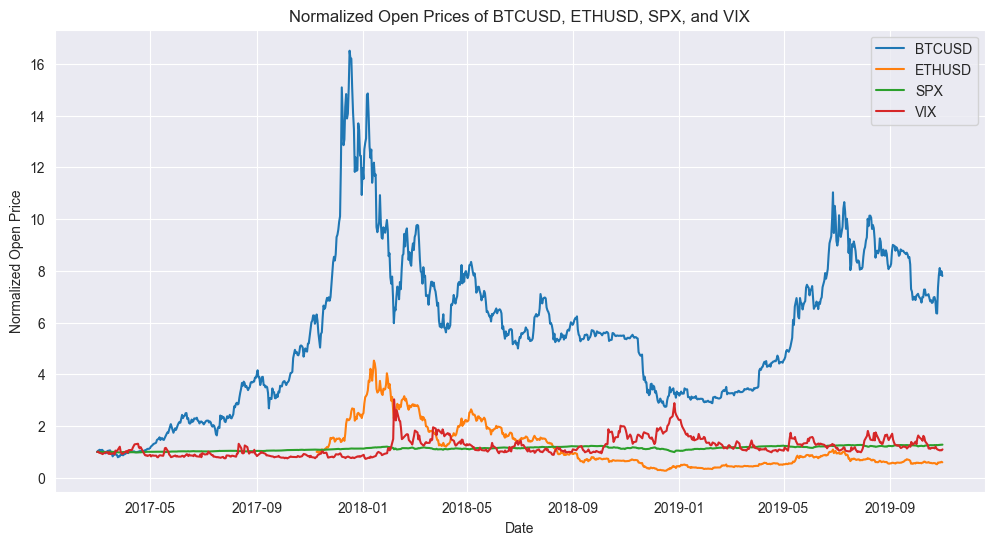

In [42]:
plt.figure(figsize=(12, 6))

plt.plot(btc_normalized, label='BTCUSD')
plt.plot(eth_normalized, label='ETHUSD')
plt.plot(spx_normalized, label='SPX')
plt.plot(vix_normalized, label='VIX')

plt.title('Normalized Open Prices of BTCUSD, ETHUSD, SPX, and VIX')
plt.xlabel('Date')
plt.ylabel('Normalized Open Price')
plt.legend()

plt.show()

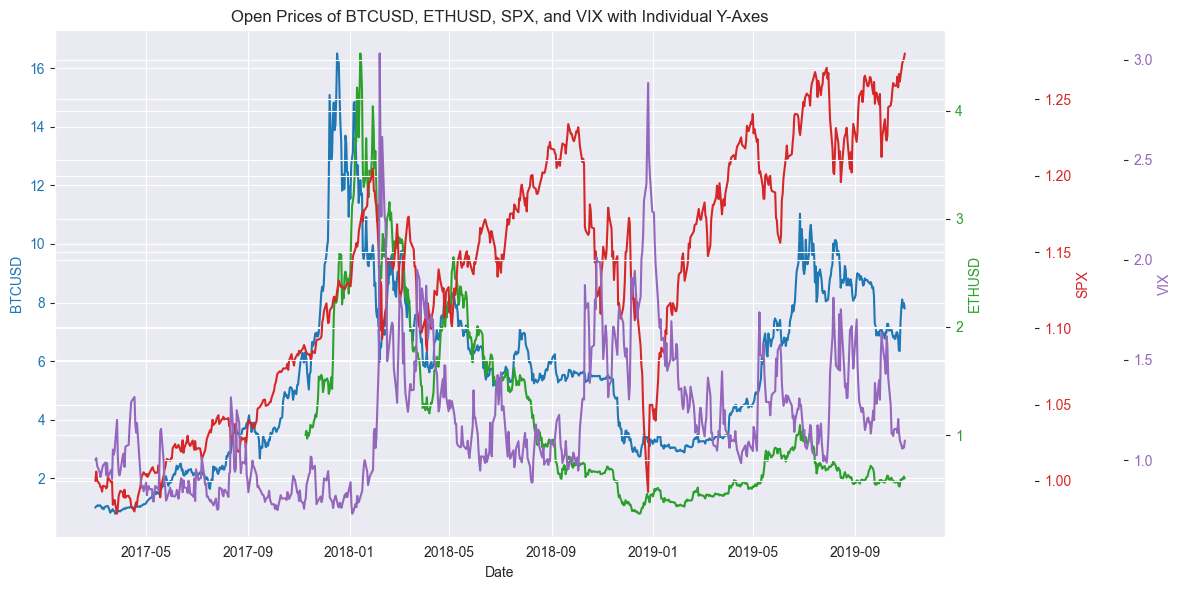

In [43]:
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot BTCUSD
color = 'tab:blue'
ax1.set_xlabel('Date')
ax1.set_ylabel('BTCUSD', color=color)
ax1.plot(btc_normalized.index, btc_normalized, color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Create and plot on the second y-axis for ETHUSD
ax2 = ax1.twinx()
color = 'tab:green'
ax2.set_ylabel('ETHUSD', color=color)
ax2.plot(eth_normalized.index, eth_normalized, color=color)
ax2.tick_params(axis='y', labelcolor=color)

# Create and plot on the third y-axis for SPX
ax3 = ax1.twinx()
color = 'tab:red'
ax3.spines["right"].set_position(("axes", 1.1))  # Offset the SPX axis to the right
ax3.set_ylabel('SPX', color=color)
ax3.plot(spx_normalized.index, spx_normalized, color=color)
ax3.tick_params(axis='y', labelcolor=color)

# Create and plot on the fourth y-axis for VIX
ax4 = ax1.twinx()
color = 'tab:purple'
ax4.spines["right"].set_position(("axes", 1.2))  # Offset the VIX axis further to the right
ax4.set_ylabel('VIX', color=color)
ax4.plot(vix_normalized.index, vix_normalized, color=color)
ax4.tick_params(axis='y', labelcolor=color)

# Title and show plot
plt.title('Open Prices of BTCUSD, ETHUSD, SPX, and VIX with Individual Y-Axes')
fig.tight_layout()  # Adjust layout to fit
plt.show()

In [49]:
print("Correlation coefficients: ETH", btc_normalized.corr(eth_normalized)," SPX : ", btc_normalized.corr(spx_normalized), " VIX: ", btc_normalized.corr(vix_normalized))

Correlation coefficients: ETH 0.6190585477547156  SPX :  nan  VIX:  nan


In [ ]:
prices['return'] = np.log(df['price'] / df['price'].shift(1))

# Drop rows with NaN in 'return' column
df = df.dropna(subset=['return'])

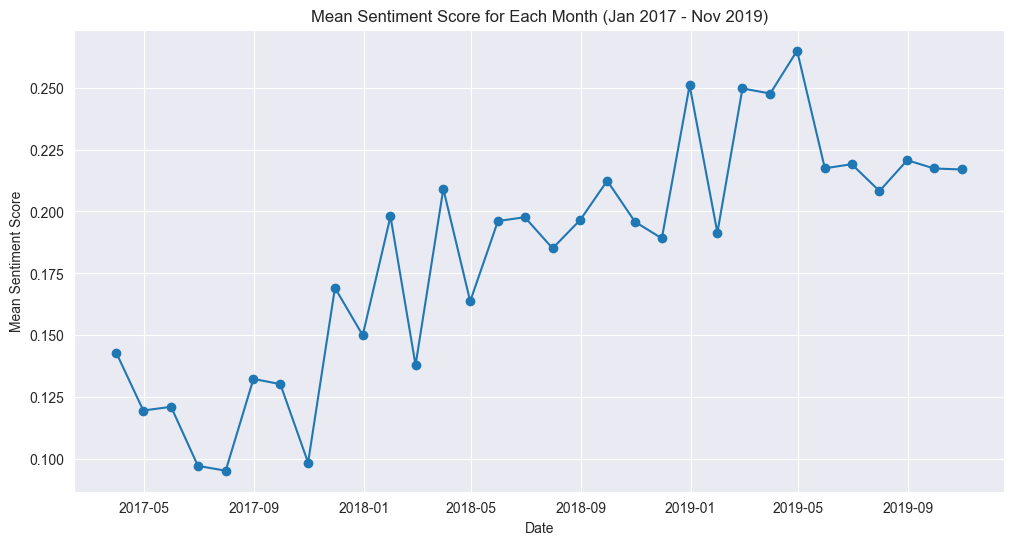

In [56]:
# Group the data by month and calculate the mean sentiment score for each month
monthly_means = tweets_analysis_nospam.resample('M', on='timestamp')['compound_sentiment'].mean()

# Plot the mean sentiment scores for each month
plt.figure(figsize=(12, 6))
plt.plot(monthly_means, marker='o', linestyle='-')
plt.xlabel('Date')
plt.ylabel('Mean Sentiment Score')
plt.title('Mean Sentiment Score for Each Month (Jan 2017 - Nov 2019)')
plt.grid(True)
plt.show()

In [58]:
# Calculate weights for each tweet
tweets_analysis_nospam['weight'] = tweets_analysis_nospam.apply(calculate_weights, axis=1)
# Group the tweets published on the same day using their weights
tweets_analysis_nospam_daily = tweets_analysis_nospam.groupby(tweets_analysis_nospam['timestamp'].dt.date).apply(weighted_average).reset_index()
tweets_analysis_nospam_daily.columns = ['timestamp', 'weighted_avg_sentiment']
tweets_analysis_nospam_daily['weighted_avg_sentiment change']=tweets_analysis_nospam_daily['weighted_avg_sentiment'].diff()
tweets_analysis_nospam_daily['updown']=(tweets_analysis_nospam_daily['weighted_avg_sentiment change'] > 0).astype(int)*2-1
tweets_analysis_nospam_daily = tweets_analysis_nospam_daily.dropna(subset=['weighted_avg_sentiment change'])
# Print the resulting df_vader DataFrame
print(tweets_analysis_nospam_daily)

KeyboardInterrupt: 

In [204]:
# Convert 'timestamp' to datetime if it's not already
tweets_analysis_nospam['timestamp'] = pd.to_datetime(tweets_analysis_nospam['timestamp'])

# Group by date and count tweets
daily_tweet_counts = tweets_analysis_nospam.groupby(pd.Grouper(key='timestamp', freq='D')).size()
daily_tweet_counts = daily_tweet_counts.reset_index(name='Volume')
daily_tweet_counts['dVolume']=daily_tweet_counts['Volume'].pct_change()
print(daily_tweet_counts)

                    timestamp  Volume   dVolume
0   2017-03-01 00:00:00+00:00       9       NaN
1   2017-03-02 00:00:00+00:00      19  1.111111
2   2017-03-03 00:00:00+00:00       4 -0.789474
3   2017-03-04 00:00:00+00:00       9  1.250000
4   2017-03-05 00:00:00+00:00       8 -0.111111
..                        ...     ...       ...
970 2019-10-27 00:00:00+00:00    3708 -0.312824
971 2019-10-28 00:00:00+00:00    4542  0.224919
972 2019-10-29 00:00:00+00:00    4170 -0.081902
973 2019-10-30 00:00:00+00:00    4111 -0.014149
974 2019-10-31 00:00:00+00:00    4559  0.108976

[975 rows x 3 columns]


In [129]:
btc=btcusd[['Close']]
btc['Log']=np.log(btc['Close'])
btc['Return']=btc['Log'].diff()
btc['updown']=(btc['Return'] > 0).astype(int)*2-1
btc = btc.dropna(subset=['Return'])
btc.index = pd.to_datetime(btc.index)
btc.index = btc.index.strftime('%Y-%m-%d')
btc.head()

/var/folders/rh/41k8kg5x2js8n7lgg1fb7bj40000gn/T/ipykernel_3598/2797591018.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  btc['Log']=np.log(btc['Close'])
/var/folders/rh/41k8kg5x2js8n7lgg1fb7bj40000gn/T/ipykernel_3598/2797591018.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  btc['Return']=btc['Log'].diff()
/var/folders/rh/41k8kg5x2js8n7lgg1fb7bj40000gn/T/ipykernel_3598/2797591018.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

,Close,Log,Return,updown
Date,,,,
2017-03-02 00:00:00+00:00,1251.010010,7.131707,0.023053,1
2017-03-03 00:00:00+00:00,1274.989990,7.150694,0.018987,1
2017-03-04 00:00:00+00:00,1255.150024,7.135010,-0.015683,-1
2017-03-05 00:00:00+00:00,1267.119995,7.144502,0.009491,1
2017-03-06 00:00:00+00:00,1272.829956,7.148998,0.004496,1


In [152]:
# Calculate the correlation between scaled sentiment and daily returns
correlation = tweets_analysis_nospam_daily['weighted_avg_sentiment'].corr(btc['Close']) #.reindex(tweets_analysis_nospam_daily.index))
correlation_2 = tweets_analysis_nospam_daily['weighted_avg_sentiment change'].corr(btc['Return']#reindex(tweets_analysis_nospam_daily.index))
correlation_3 = tweets_analysis_nospam_daily['updown'].corr(btc['updown']#reindex(tweets_analysis_nospam_daily.index))
# Print the correlation
print(f"Correlation between scaled sentiment and price of BTC: {correlation:.3f}")
print(f"Correlation between scaled sentiment and movement of BTC price: {correlation_2:.3f}")
print(f"Correlation between scaled sentiment and movement of BTC price: {correlation_3:.3f}")

Correlation between scaled sentiment and price of BTC: 0.125
Correlation between scaled sentiment and movement of BTC price: 0.034
Correlation between scaled sentiment and movement of BTC price: 0.008


In [160]:
for lag in range(1, 6):  # Example: Check lags 1 to 5
    tweets_analysis_nospam_daily['series2_lagged'] = tweets_analysis_nospam_daily['weighted_avg_sentiment change'].shift(lag)
    correlation = tweets_analysis_nospam_daily['weighted_avg_sentiment change'].corr(tweets_analysis_nospam_daily['series2_lagged'])
    print(f"Lag: {lag}, Correlation: {correlation}")

Lag: 1, Correlation: -0.488921896767559
Lag: 2, Correlation: -0.018807993883145187
Lag: 3, Correlation: 0.002160524613397732
Lag: 4, Correlation: -0.02502480179262709
Lag: 5, Correlation: 0.06112732076218217


In [164]:
btc['timestamp'] = pd.to_datetime(btc['timestamp'])
#df2['timestamp'] = pd.to_datetime(df2['timestamp'])
merged_df = pd.merge(btc, tweets_analysis_nospam_daily, on='timestamp', how='left')

,Date,Close,Log,Return,updown_x,timestamp,series2_lagged_x,weighted_avg_sentiment,weighted_avg_sentiment change,updown_y,series2_lagged_y
0,2017-03-03,1274.989990,7.150694,0.018987,1,2017-03-03,NaN,-0.745156,-1.032822,-1,NaN
1,2017-03-04,1255.150024,7.135010,-0.015683,-1,2017-03-04,NaN,-0.331027,0.414129,1,NaN
2,2017-03-05,1267.119995,7.144502,0.009491,1,2017-03-05,NaN,0.116107,0.447134,1,NaN
3,2017-03-06,1272.829956,7.148998,0.004496,1,2017-03-06,NaN,0.323555,0.207448,1,NaN
4,2017-03-07,1223.540039,7.109504,-0.039494,-1,2017-03-07,NaN,0.441394,0.117839,1,NaN
5,2017-03-08,1150.000000,7.047517,-0.061986,-1,2017-03-08,1274.989990,0.569125,0.127731,1,-1.032822
6,2017-03-09,1188.489990,7.080439,0.032922,1,2017-03-09,1255.150024,0.565034,-0.004091,-1,0.414129
7,2017-03-10,1116.719971,7.018151,-0.062288,-1,2017-03-10,1267.119995,-0.446556,-1.011590,-1,0.447134
8,2017-03-11,1175.829956,7.069730,0.051578,1,2017-03-11,1272.829956,-0.239485,0.207072,1,0.207448
9,2017-03-12,1221.380005,7.107737,0.038007,1,2017-03-12,1223.540039,0.172251,0.411736,1,0.117839


In [177]:
columns_to_drop = ['series2_lagged_y']
# Drop the columns
merged_df = merged_df.drop(columns=columns_to_drop, axis=1)
# Dictionary of old column names to new column names
rename_columns = {'Close': 'Price', 'weighted_avg_sentiment': 'WAS', 'weighted_avg_sentiment change': 'dWAS', 'updown_x': 'UD_btc', 'updown_y': 'UD_dWAS'}
# Rename the columns
merged_df = merged_df.rename(columns=rename_columns)
merged_df.head(10)

,Date,Price,Log,Return,updown_btc,weighted_avg_sentiment,weighted_avg_sentiment change,updown_sent
0,2017-03-03,1274.989990,7.150694,0.018987,1,-0.745156,-1.032822,-1
1,2017-03-04,1255.150024,7.135010,-0.015683,-1,-0.331027,0.414129,1
2,2017-03-05,1267.119995,7.144502,0.009491,1,0.116107,0.447134,1
3,2017-03-06,1272.829956,7.148998,0.004496,1,0.323555,0.207448,1
4,2017-03-07,1223.540039,7.109504,-0.039494,-1,0.441394,0.117839,1
5,2017-03-08,1150.000000,7.047517,-0.061986,-1,0.569125,0.127731,1
6,2017-03-09,1188.489990,7.080439,0.032922,1,0.565034,-0.004091,-1
7,2017-03-10,1116.719971,7.018151,-0.062288,-1,-0.446556,-1.011590,-1
8,2017-03-11,1175.829956,7.069730,0.051578,1,-0.239485,0.207072,1
9,2017-03-12,1221.380005,7.107737,0.038007,1,0.172251,0.411736,1


In [207]:
# Ensure the date column in merged_df is of datetime type
merged_df['Date'] = pd.to_datetime(merged_df['Date'])
# Convert timezone-aware to timezone-naive
daily_tweet_counts['timestamp'] = daily_tweet_counts['timestamp'].dt.tz_convert(None)

# Merge the tweet counts into merged_df on the date column
merged_df = merged_df.merge(daily_tweet_counts, left_on='Date', right_on='timestamp', how='left')

# Drop the extra 'timestamp' column after merge
merged_df.drop('timestamp', axis=1, inplace=True)

merged_df.head()

,Date,Price,Log,Return,UD_btc,WAS,dWAS,UD_dWAS,Volume,dVolume
0,2017-03-03,1274.989990,7.150694,0.018987,1,-0.745156,-1.032822,-1,4,-0.789474
1,2017-03-04,1255.150024,7.135010,-0.015683,-1,-0.331027,0.414129,1,9,1.250000
2,2017-03-05,1267.119995,7.144502,0.009491,1,0.116107,0.447134,1,8,-0.111111
3,2017-03-06,1272.829956,7.148998,0.004496,1,0.323555,0.207448,1,8,0.000000
4,2017-03-07,1223.540039,7.109504,-0.039494,-1,0.441394,0.117839,1,6,-0.250000


In [220]:
# List of variables to create lags for
variables = ['Price', 'Return', 'WAS', 'dWAS', 'Volume', 'dVolume']

# Number of lags
n_lags = 5

# Create lagged variables
for var in variables:
    for lag in range(1, n_lags + 1):
        merged_df[f'{var}_lag_{lag}'] = merged_df[var].shift(lag)
merged_df.dropna(inplace=True)
merged_df.head()

,Date,Price,Log,Return,UD_btc,WAS,dWAS,UD_dWAS,Volume,dVolume,...,Price_lag_1,Price_lag_2,Price_lag_3,Price_lag_4,Price_lag_5,Return_lag_1,Return_lag_2,Return_lag_3,Return_lag_4,Return_lag_5
0,2017-03-03,1274.989990,7.150694,0.018987,1,-0.745156,-1.032822,-1,4,-0.789474,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2017-03-04,1255.150024,7.135010,-0.015683,-1,-0.331027,0.414129,1,9,1.250000,...,1274.989990,NaN,NaN,NaN,NaN,0.018987,NaN,NaN,NaN,NaN
2,2017-03-05,1267.119995,7.144502,0.009491,1,0.116107,0.447134,1,8,-0.111111,...,1255.150024,1274.989990,NaN,NaN,NaN,-0.015683,0.018987,NaN,NaN,NaN
3,2017-03-06,1272.829956,7.148998,0.004496,1,0.323555,0.207448,1,8,0.000000,...,1267.119995,1255.150024,1274.989990,NaN,NaN,0.009491,-0.015683,0.018987,NaN,NaN
4,2017-03-07,1223.540039,7.109504,-0.039494,-1,0.441394,0.117839,1,6,-0.250000,...,1272.829956,1267.119995,1255.150024,1274.98999,NaN,0.004496,0.009491,-0.015683,0.018987,NaN


In [226]:
merged_df_train=merged_df[merged_df['Date']<pd.to_datetime('2018-01-01')]
merged_df_train.head()

,Date,Price,Log,Return,UD_btc,WAS,dWAS,UD_dWAS,Volume,dVolume,...,Price_lag_1,Price_lag_2,Price_lag_3,Price_lag_4,Price_lag_5,Return_lag_1,Return_lag_2,Return_lag_3,Return_lag_4,Return_lag_5
5,2017-03-08,1150.000000,7.047517,-0.061986,-1,0.569125,0.127731,1,7,0.166667,...,1223.540039,1272.829956,1267.119995,1255.150024,1274.989990,-0.039494,0.004496,0.009491,-0.015683,0.018987
6,2017-03-09,1188.489990,7.080439,0.032922,1,0.565034,-0.004091,-1,4,-0.428571,...,1150.000000,1223.540039,1272.829956,1267.119995,1255.150024,-0.061986,-0.039494,0.004496,0.009491,-0.015683
7,2017-03-10,1116.719971,7.018151,-0.062288,-1,-0.446556,-1.011590,-1,11,1.750000,...,1188.489990,1150.000000,1223.540039,1272.829956,1267.119995,0.032922,-0.061986,-0.039494,0.004496,0.009491
8,2017-03-11,1175.829956,7.069730,0.051578,1,-0.239485,0.207072,1,11,0.000000,...,1116.719971,1188.489990,1150.000000,1223.540039,1272.829956,-0.062288,0.032922,-0.061986,-0.039494,0.004496
9,2017-03-12,1221.380005,7.107737,0.038007,1,0.172251,0.411736,1,19,0.727273,...,1175.829956,1116.719971,1188.489990,1150.000000,1223.540039,0.051578,-0.062288,0.032922,-0.061986,-0.039494


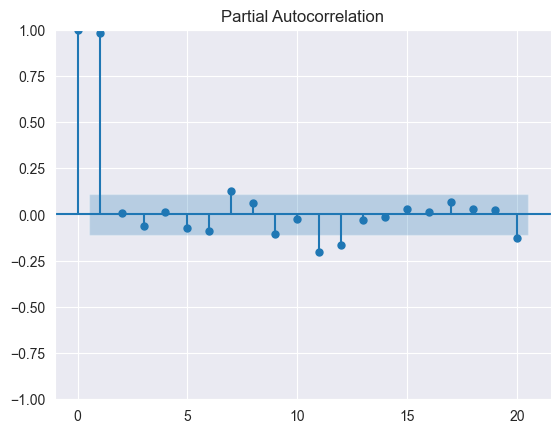

In [227]:
import statsmodels.api as sm
# Assuming df is your DataFrame and 'time_series_column' is the column with time series data
sm.graphics.tsa.plot_pacf(merged_df_train['Price'], lags=20)  # You can adjust the number of lags
plt.show()

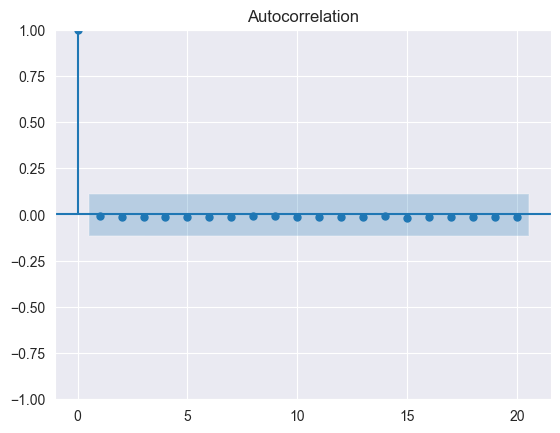

In [228]:
# Assuming 'time_series_column' is the column with your time series data
sm.graphics.tsa.plot_acf(merged_df_train['dVolume'], lags=20)  # Adjust the number of lags as needed
plt.show()

In [230]:
# Assuming 'time_series1' is the column you want to predict and 'time_series2' is the potential predictor
# The maxlag parameter defines the number of lags to test for
from statsmodels.tsa.stattools import grangercausalitytests
grangercausalitytests(merged_df_train[['Return', 'Volume_lag_1']], maxlag=5, verbose=True)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.9042  , p=0.0894  , df_denom=295, df_num=1
ssr based chi2 test:   chi2=2.9337  , p=0.0867  , df=1
likelihood ratio test: chi2=2.9194  , p=0.0875  , df=1
parameter F test:         F=2.9042  , p=0.0894  , df_denom=295, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.2480  , p=0.1074  , df_denom=292, df_num=2
ssr based chi2 test:   chi2=4.5730  , p=0.1016  , df=2
likelihood ratio test: chi2=4.5381  , p=0.1034  , df=2
parameter F test:         F=2.2480  , p=0.1074  , df_denom=292, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.9140  , p=0.1274  , df_denom=289, df_num=3
ssr based chi2 test:   chi2=5.8811  , p=0.1175  , df=3
likelihood ratio test: chi2=5.8234  , p=0.1205  , df=3
parameter F test:         F=1.9140  , p=0.1274  , df_denom=289, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.0861  , p=0.0827  

/Users/mehdimouden/Desktop/EPFL/IF/MA3/Fin Machine Learning/BTC NLP/venv/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


{1: ({'ssr_ftest': (2.9041867877543437, 0.08940276785076487, 295.0, 1),
   'ssr_chi2test': (2.933720890680659, 0.08674734968609035, 1),
   'lrtest': (2.9193741708236303, 0.08752180268308392, 1),
   'params_ftest': (2.904186787752306, 0.08940276785087628, 295.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (2.247995429351572, 0.10743550120697863, 292.0, 2),
   'ssr_chi2test': (4.572977003543951, 0.10162268392579228, 2),
   'lrtest': (4.5381286731148975, 0.1034088907504366, 2),
   'params_ftest': (2.247995429355692, 0.10743550120654202, 292.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (1.9139954281984166, 0.12740233312071844, 289.0, 3),
   'ssr_chi2test': (5.881065537163301, 0.11754222057949887, 3),
   'lrtest': (5.823404176263921, 0.12052532624127225, 3),
   'params_ftest': (1.9139954281911677, 0.1274023331219002, 289.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [0., 0., 0

In [231]:
from statsmodels.tsa.stattools import adfuller
# Assuming 'time_series_column' is your time series data
result = adfuller(merged_df_train['Price'])

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))


ADF Statistic: 2.327805
p-value: 0.998972
Critical Values:
	1%: -3.454
	5%: -2.872
	10%: -2.572


In [234]:
# Define the dependent (y) and independent (X) variables
y = merged_df_train['Return']
X = merged_df_train[['dWAS','WAS', 'UD_dWAS', 'Volume', 'dVolume', 'Volume_lag_1', 'dVolume_lag_1', 'dWAS_lag_1', 'WAS_lag_1', 'Price_lag_1']]

# Add a constant to the independent variable
X = sm.add_constant(X)

# Create the model
model = sm.OLS(y, X)

# Fit the model
results = model.fit()

# Print the summary
print(results.summary())


                            OLS Regression Results                            
Dep. Variable:                 Return   R-squared:                       0.020
Model:                            OLS   Adj. R-squared:                 -0.011
Method:                 Least Squares   F-statistic:                    0.6554
Date:                Sat, 02 Dec 2023   Prob (F-statistic):              0.749
Time:                        15:28:42   Log-Likelihood:                 467.20
No. Observations:                 299   AIC:                            -914.4
Df Residuals:                     289   BIC:                            -877.4
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0079      0.005      1.532